## Model Training

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
import pandas as pd
import numpy as np
import json
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder , StandardScaler
from sklearn.linear_model import LogisticRegressionCV ,SGDClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score ,classification_report,confusion_matrix,precision_score
from sklearn.model_selection import RandomizedSearchCV ,StratifiedKFold,StratifiedShuffleSplit
from sklearn.impute import SimpleImputer
from datetime import datetime

In [4]:
def confusion_matrix_cr(cm, labels=None, title='Confusion Matrix'):
    """
    Plots a confusion matrix as a heatmap.
    
    Parameters:
        cm (array-like): Confusion matrix (2D list or NumPy array)
        labels (list): List of class names for axes labels
        title (str): Title for the plot
    """
    cm = np.array(cm)  # ensure it's a NumPy array
    
    if labels is None:
        labels = [f'Class {i}' for i in range(cm.shape[0])]  # default labels

    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=labels, yticklabels=labels)
    plt.title(title, fontsize=14)
    plt.xlabel('Predicted Labels', fontsize=12)
    plt.ylabel('True Labels', fontsize=12)
    plt.show()


In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

def plot_multiclass_roc(cm, labels):
    """
    Plot ROC curve for a multiclass confusion matrix.

    Parameters:
    -----------
    cm : numpy.ndarray
        Confusion matrix (n_classes x n_classes)
    labels : list
        List of class names
    """

 
    y_true, y_pred = [], []
    for i in range(len(labels)):
        for j in range(len(labels)):
            y_true += [i] * cm[i, j]
            y_pred += [j] * cm[i, j]

    y_true = np.array(y_true)
    y_pred = np.array(y_pred)


    y_true_bin = label_binarize(y_true, classes=list(range(len(labels))))
    y_pred_bin = label_binarize(y_pred, classes=list(range(len(labels))))


    fpr, tpr, roc_auc = {}, {}, {}
    for i in range(len(labels)):
        fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_pred_bin[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])


    fpr["micro"], tpr["micro"], _ = roc_curve(y_true_bin.ravel(), y_pred_bin.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])


    plt.figure(figsize=(8, 6))
    for i, label in enumerate(labels):
        plt.plot(fpr[i], tpr[i], lw=2,
                 label=f'{label} (AUC = {roc_auc[i]:.2f})')

    plt.plot(fpr["micro"], tpr["micro"],
             label=f'Micro-average (AUC = {roc_auc["micro"]:.2f})',
             color='black', linestyle='--', lw=2)


    plt.plot([0, 1], [0, 1], 'k--', lw=1)

    plt.title('Multiclass ROC Curve')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend(loc='lower right')
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()


In [13]:
def evaluate_confusion_matrix(cm, labels):
    """
    Evaluate a confusion matrix and provide accuracy, average F1-score,
    and interpretation regarding underfitting/overfitting.

    Parameters:
    - cm: numpy array, confusion matrix
    - labels: list of strings, class labels in order

    Returns:
    - dict containing accuracy, average F1-score, and interpretation
    """
    # Compute accuracy
    accuracy = np.trace(cm) / np.sum(cm)

    # Compute per-class precision, recall, F1
    true_labels = np.repeat(np.arange(len(labels)), cm.sum(axis=1))
    pred_labels = np.concatenate([np.repeat(i, cm[:, i].sum()) for i in range(len(labels))])

    report = classification_report(true_labels, pred_labels, target_names=labels, output_dict=True)
    avg_f1 = np.mean([report[label]['f1-score'] for label in labels])

    # --- Interpretation logic ---
    if accuracy < 0.7 and avg_f1 < 0.7:
        result = "Underfitting (model not learning enough, poor generalization)."
    elif accuracy > 0.9 and avg_f1 > 0.85:
        result = "Good generalization (no clear overfitting visible from test set)."
    elif accuracy > 0.9 and avg_f1 < 0.7:
        result = "Model may be overfitting or biased towards certain classes."
    else:
        result = "Model performance is moderate, possibly mild underfitting or class imbalance."
    

    print(f"Test Accuracy: {accuracy:.2f}")
    print(f"Average F1-score: {avg_f1:.2f}")
    print("Interpretation:", result)

    return {
        "accuracy": accuracy,
        "average_f1": avg_f1,
        "interpretation": result
    }


In [3]:
train_data = pd.read_csv(r'/content/drive/MyDrive/data/train_data.csv')
test_data = pd.read_csv(r'/content/drive/MyDrive/data/test_data.csv')
y_train= train_data['IncidentGrade']
y_test=test_data['IncidentGrade']
x_train , x_test = train_data,test_data
x_train.drop(columns=['IncidentGrade'],axis=1,inplace=True)
x_test.drop(columns=['IncidentGrade'],axis=1,inplace=True)


In [4]:
x_test

,Unnamed: 0,0,1,2,3,4,5,6,7,8,...,25,26,27,28,29,30,31,32,33,34
0,160465,-0.200881,0.731599,1.362965,1.010388,0.578267,-0.200442,-0.240822,0.279292,-0.646468,...,0.015194,0.337131,0.314873,0.02729,0.143503,0.143616,-2.541944,-3.412244,-3.556293,-1.537973
1,1352735,-0.637064,-0.349634,-0.534017,-0.887929,-1.222142,-0.090227,-0.238236,-2.082191,-0.646468,...,0.015194,0.337131,0.314873,0.02729,0.143503,0.143616,0.304288,0.276908,0.276735,0.650207
2,293916,0.200408,-0.333456,-0.549576,-0.890535,-1.222142,0.213476,-0.227701,-1.295030,1.434189,...,0.015194,0.337131,0.314873,0.02729,0.143503,0.143616,0.304288,0.276908,0.276735,0.650207
3,2330886,0.863407,1.235815,-0.135166,-0.690203,-0.321938,3.282348,0.041612,1.853614,1.434189,...,0.015194,0.337131,0.314873,0.02729,0.143503,0.143616,0.304288,0.276908,0.276735,-1.537973
4,2065675,0.531907,-0.446702,-0.556872,-0.894493,0.578267,-0.217586,-0.176654,0.016905,-0.646468,...,0.015194,0.337131,0.314873,0.02729,0.143503,0.143616,0.304288,0.276908,0.276735,0.650207
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3995,2198201,0.933196,-0.430524,-0.256389,0.520615,-1.222142,-0.188196,-0.212473,-0.507869,0.003738,...,0.015194,0.337131,0.314873,0.02729,0.143503,0.143616,0.304288,0.276908,0.276735,-1.537973
3996,3140085,-1.683905,1.055160,-0.126801,1.238977,0.578267,-0.237180,-0.241971,0.279292,-0.646468,...,0.015194,0.337131,0.314873,0.02729,0.143503,0.143616,-3.111190,0.276908,0.276735,0.650207
3997,2177086,0.898301,-0.462881,-0.552401,-0.893810,0.578267,-0.227383,-0.241588,0.279292,-0.256344,...,0.015194,0.337131,0.314873,0.02729,0.143503,0.143616,0.304288,0.276908,0.276735,0.650207
3998,1009620,0.444671,0.027854,0.309277,-0.827425,-1.222142,0.644539,-0.146965,-0.507869,-0.646468,...,0.015194,0.337131,0.314873,0.02729,0.143503,0.143616,0.304288,0.276908,0.276735,0.650207


In [5]:
x_train.drop(columns=['Unnamed: 0'],axis=1,inplace=True)
x_test.drop(columns=['Unnamed: 0'],axis=1,inplace=True)



In [6]:
y_train.value_counts() / len(y_train) * 100

,count
IncidentGrade,
0,43.733333
2,34.913333
1,21.353333


### Class Balancing

In [7]:
!pip install imblearn

In [8]:
from imblearn.over_sampling import RandomOverSampler
from imblearn.over_sampling import SMOTE
smote = SMOTE(random_state=42)
x_resampled_train, y_resampled_train = smote.fit_resample(x_train, y_train)


In [9]:
y_resampled_train.value_counts() #class distributio same


,count
IncidentGrade,
0,6560
2,6560
1,6560


# Decision Tree

In [ ]:
dtree = DecisionTreeClassifier(criterion='gini', splitter='best', max_depth= 20, min_samples_split=4, min_samples_leaf=1,
                               max_features= 'log2', random_state=42)

# Evaluate the model on validation data
dtree = dtree.fit(x_resampled_train,y_resampled_train)
x_test = x_test[x_resampled_train.columns]
y_pred = dtree.predict(x_test)
print("\nClassification Report:")
print(classification_report(y_test, y_pred))
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))


Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.90      0.88     11720
           1       0.92      0.92      0.92     13464
           2       0.99      0.99      0.99    126942

    accuracy                           0.98    152126
   macro avg       0.92      0.94      0.93    152126
weighted avg       0.98      0.98      0.98    152126

Confusion Matrix:
[[ 10596    576    548]
 [   639  12454    371]
 [  1142    512 125288]]


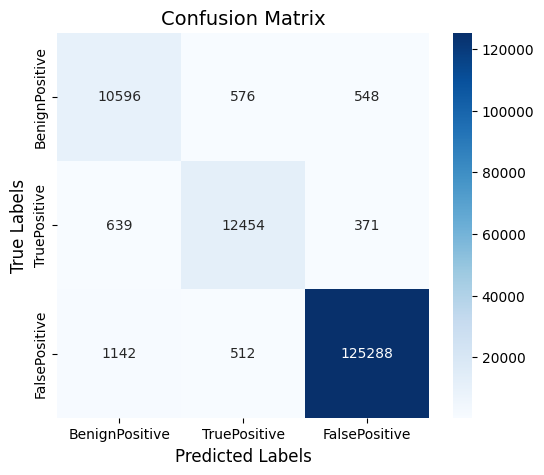

In [18]:
cm = np.array([
    [10596, 576, 548],
    [639, 12454, 371],
    [1142, 512, 125288]
])

labels =  ['BenignPositive', 'TruePositive', 'FalsePositive']
confusion_matrix_cr(cm,labels)

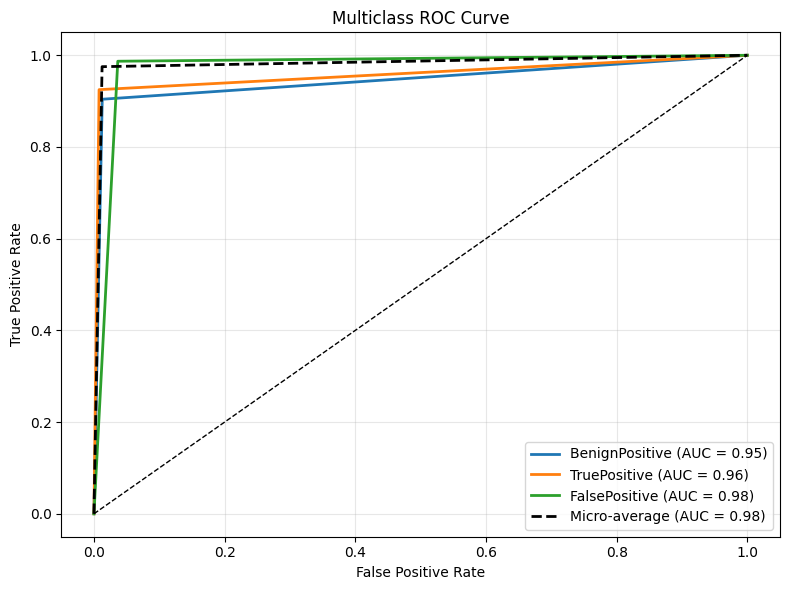

In [8]:
plot_multiclass_roc(cm, labels)

In [19]:
results = evaluate_confusion_matrix(cm, labels)

Test Accuracy: 0.98
Average F1-score: 0.97
Interpretation: Good generalization (no clear overfitting visible from test set).


# Random Forest Classifier

In [13]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold, train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from scipy.stats import randint

x_test = x_test[x_resampled_train.columns]

# Initialize Random Forest Classifier
rf = RandomForestClassifier(n_estimators = 200, min_samples_split = 2, min_samples_leaf = 1, max_features = None, max_depth = 30,
                            bootstrap = True, random_state=42)
rf

RandomForestClassifier(max_depth=30, max_features=None, n_estimators=200,
                       random_state=42)

In [ ]:
rf = rf.fit(x_resampled_train,y_resampled_train)
# Evaluate the best model on validation data
y_pred = rf.predict(x_test)

# Print results
print("\nClassification Report:")
print(classification_report(y_test, y_pred))
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))


Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.98      0.98     11720
           1       0.97      0.98      0.97     13464
           2       1.00      1.00      1.00    126942

    accuracy                           0.99    152126
   macro avg       0.98      0.98      0.98    152126
weighted avg       0.99      0.99      0.99    152126

Confusion Matrix:
[[ 11440    209     71]
 [   175  13142    147]
 [    99    167 126676]]


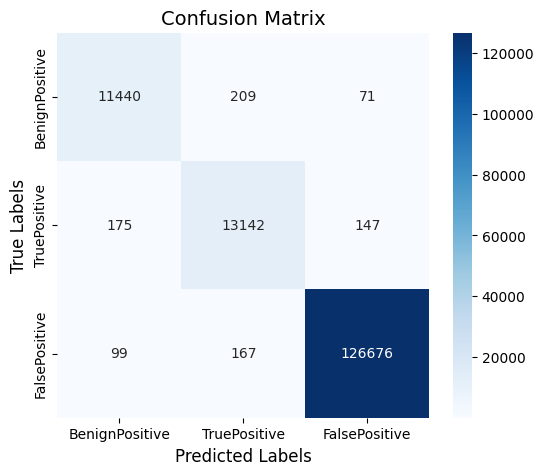

In [16]:
cm = np.array([
    [11440, 209, 71],
    [175, 13142, 147],
    [99, 167, 126676]
])


labels =  ['BenignPositive', 'TruePositive', 'FalsePositive']
confusion_matrix_cr(cm,labels)

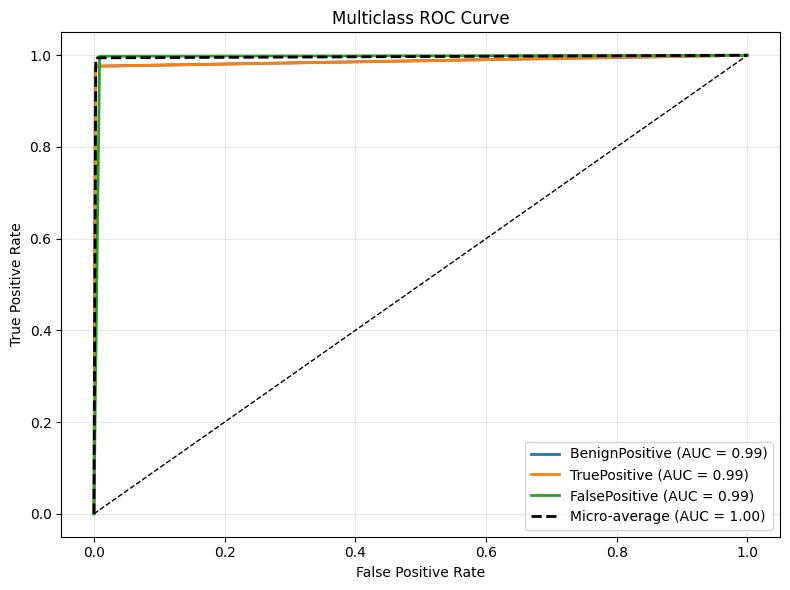

In [10]:
plot_multiclass_roc(cm, labels)

In [17]:
results = evaluate_confusion_matrix(cm, labels)

Test Accuracy: 0.99
Average F1-score: 1.00
Interpretation: Good generalization (no clear overfitting visible from test set).


# Logistic Regression


In [14]:
logreg = LogisticRegression(C = 100, penalty = 'l1', solver='liblinear')
logreg

LogisticRegression(C=100, penalty='l1', solver='liblinear')

In [ ]:


logreg = logreg.fit(x_resampled_train,y_resampled_train)
x_test = x_test[x_resampled_train.columns]
# Evaluate the model on validation data
y_pred = logreg.predict(x_test)

# Print results
print("Classification Report:")
print(classification_report(y_test, y_pred))
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

Classification Report:
              precision    recall  f1-score   support

           0       0.62      0.61      0.62      1690
           1       0.41      0.41      0.41       871
           2       0.68      0.69      0.68      1439

    accuracy                           0.60      4000
   macro avg       0.57      0.57      0.57      4000
weighted avg       0.60      0.60      0.60      4000

Confusion Matrix:
[[1034  369  287]
 [ 329  356  186]
 [ 295  152  992]]


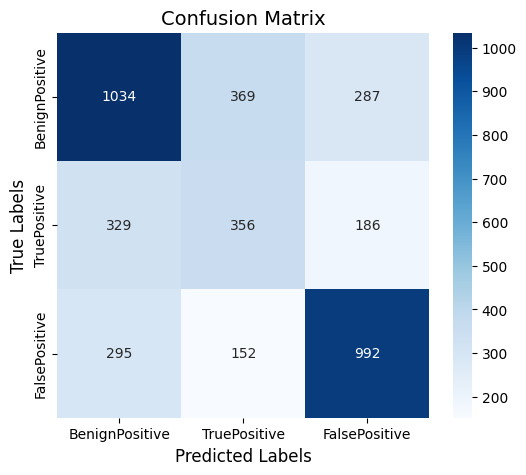

In [20]:
cm =np.array([
    [1034, 369, 287],
    [329, 356, 186],
    [295, 152, 992]
])


labels =  ['BenignPositive', 'TruePositive', 'FalsePositive']
confusion_matrix_cr(cm,labels)

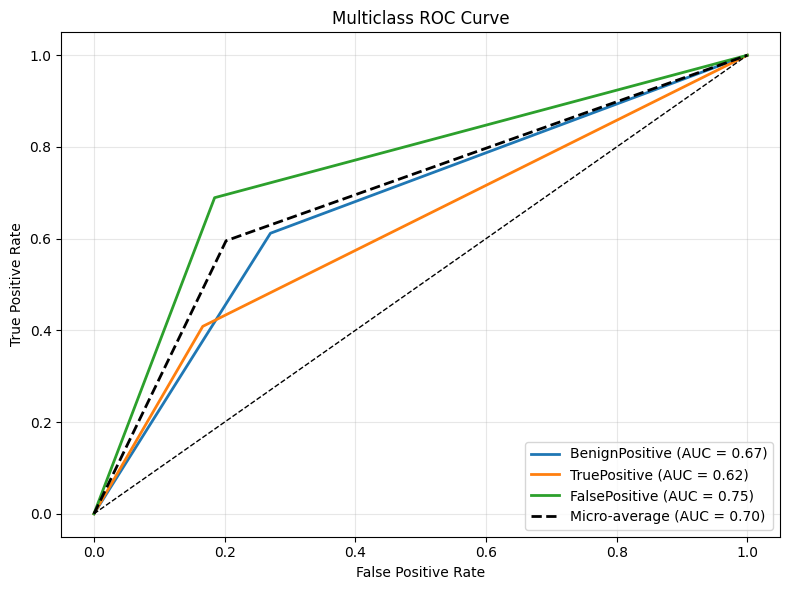

In [12]:
plot_multiclass_roc(cm, labels)

In [21]:
results = evaluate_confusion_matrix(cm, labels)

Test Accuracy: 0.60
Average F1-score: 0.98
Interpretation: Model performance is moderate, possibly mild underfitting or class imbalance.


# Saving The Best model

In [11]:
import pandas as pd

report = {
    'Model': ['Logistic Regression', 'Decision Tree', 'Random Forest'],
    'Accuracy':[0.60,0.98,0.99],
    'Macro-F1 Score':[ 0.57, 0.93, 0.98],
    'Precision': [0.57,0.92,0.98],
    'Recall': [0.57,0.94,0.98 ]

}

# Convert to DataFrame
df = pd.DataFrame(report)

# Print comparison table
print("Comparison Table:")
print(df.to_string(index=False))

# Find the best model based on Macro-F1 Score
best_model = df.loc[df['Macro-F1 Score'].idxmax()]

# Print the best model
print("\nBest Model Based on Macro-F1 Score:")
print(best_model)

Comparison Table:
              Model  Accuracy  Macro-F1 Score  Precision  Recall
Logistic Regression      0.60            0.57       0.57    0.57
      Decision Tree      0.98            0.93       0.92    0.94
      Random Forest      0.99            0.98       0.98    0.98

Best Model Based on Macro-F1 Score:
Model             Random Forest
Accuracy                   0.99
Macro-F1 Score             0.98
Precision                  0.98
Recall                     0.98
Name: 2, dtype: object


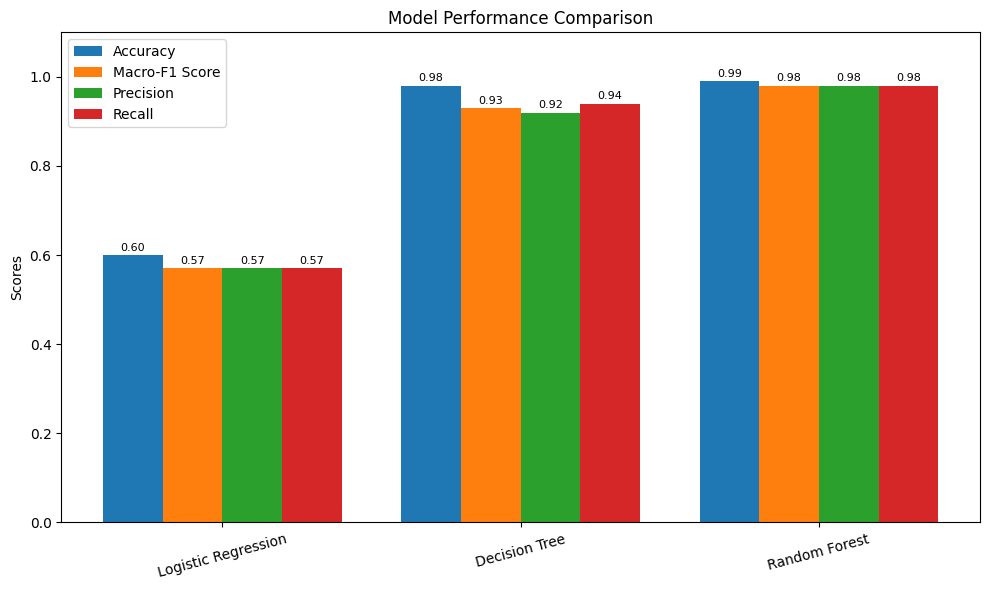

In [12]:
df.set_index('Model', inplace=True)

# Plotting
metrics = df.columns
models = df.index
x = np.arange(len(models))  # the label locations
width = 0.2  # width of each bar

fig, ax = plt.subplots(figsize=(10, 6))

# Plot bars for each metric
for i, metric in enumerate(metrics):
    ax.bar(x + i * width, df[metric], width, label=metric)

# Set labels and title
ax.set_ylabel('Scores')
ax.set_title('Model Performance Comparison')
ax.set_xticks(x + width * (len(metrics)-1) / 2)
ax.set_xticklabels(models, rotation=15)
ax.set_ylim(0, 1.1)
ax.legend()

# Add data labels on bars
for i, metric in enumerate(metrics):
    for j, val in enumerate(df[metric]):
        ax.text(x[j] + i * width, val + 0.01, f"{val:.2f}", ha='center', fontsize=8)

plt.tight_layout()
plt.show()

In [15]:
from joblib import dump
model_path = r"/content/drive/MyDrive/data/best_random_forest.pkl"
dump(rf, model_path)
print(f"Model saved to {model_path}")

Model saved to /content/drive/MyDrive/data/best_random_forest.pkl
